The data of this notebook is take from kaggle.  
The description of problem is as follows-  
This project focuses on developing a machine learning model to automatically detect diabetic retinopathy from retinal images. By leveraging a large dataset of images, the goal is to enable early diagnosis of this leading cause of blindness, particularly in underserved areas. The automated screening process aims to improve patient outcomes by facilitating timely interventions, thereby preventing vision loss. This model can also be adapted for the detection of other eye diseases, enhancing overall eye health management.

loading libraries and setting seed

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets , models
from torch.utils.data import DataLoader, Dataset
from torchvision.models import ResNet50_Weights , resnet
from torchvision.datasets import ImageFolder

torch.manual_seed(42)
np.random.seed(42)
torch.set_default_device('cuda')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# print(os.listdir('../input'))
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/aptos2019-blindness-detection/sample_submission.csv
/kaggle/input/aptos2019-blindness-detection/train.csv
/kaggle/input/aptos2019-blindness-detection/test.csv
/kaggle/input/aptos2019-blindness-detection/train_images/ef476be214d4.png
/kaggle/input/aptos2019-blindness-detection/train_images/6dcde47060f9.png
/kaggle/input/aptos2019-blindness-detection/train_images/ec363f48867b.png
/kaggle/input/aptos2019-blindness-detection/train_images/17f6c7072f61.png
/kaggle/input/aptos2019-blindness-detection/train_images/b49b2fac2514.png
/kaggle/input/aptos2019-blindness-detection/train_images/af6166d57f13.png
/kaggle/input/aptos2019-blindness-detection/train_images/8d13c46e7d75.png
/kaggle/input/aptos2019-blindness-detection/train_images/c3b15bf9b4bc.png
/kaggle/input/aptos2019-blindness-detection/train_images/be68322c7223.png
/kaggle/input/aptos2019-blindness-detection/train_images/88e4399d207c.png
/kaggle/input/aptos2019-blindness-detection/train_images/0243404e8a00.png
/kaggle/input

In [2]:
train_csv = pd.read_csv('/kaggle/input/aptos2019-blindness-detection/train.csv')
test_csv = pd.read_csv('/kaggle/input/aptos2019-blindness-detection/test.csv')
train_csv.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


test_csv does not have diagnosis. So we will split train_csv into X_train and X_valid

In [3]:
from sklearn.model_selection import train_test_split

train_data_dir = '/kaggle/input/aptos2019-blindness-detection/train_images/'
train_csv['image_path'] = train_data_dir + train_csv['id_code'] + '.png'
X = train_csv.drop(columns=['diagnosis'])
y = train_csv['diagnosis']
X_train , X_valid , y_train , y_valid = train_test_split(X,y, test_size = 0.2,random_state = 42)

Lets check one of the images

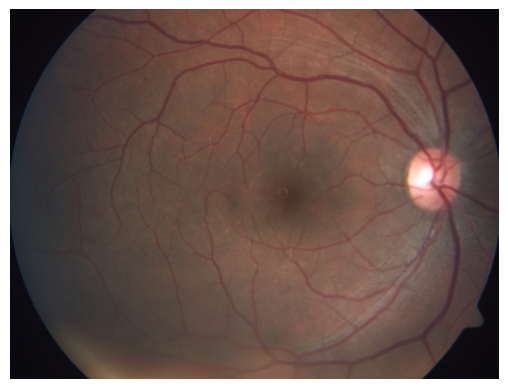

In [4]:
from PIL import Image
import matplotlib.pyplot as plt

# Load the image
img_path = '/kaggle/input/aptos2019-blindness-detection/train_images/ec363f48867b.png'
image = Image.open(img_path)

# Display the image using matplotlib
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()


**Here since our dataset is not in correct format we are using our custom Dataset class which inherit from torch's Dataset.**  

**After creating this dataset we can send it to our dataloader **

In [5]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Define transformations for training set
# Custom dataset class to load images and labels from CSV
class APTOSDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        super(APTOSDataset, self).__init__()
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Set directory paths and create DataLoader

def create_data_loader(X_train , y_train , shuffle = False):
    X_train_image_paths = list(X_train['image_path'])
    X_train_labels = list(y_train)
    data_transforms = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ])
    train_dataset = APTOSDataset(
        image_paths = X_train_image_paths,
        labels = X_train_labels,
        transform=data_transforms
    )
    loader = DataLoader(train_dataset, batch_size= 128, shuffle=shuffle, generator = torch.Generator(device = 'cuda'))
    return loader


#### To create this model we will use pretrained resnet50 and freeze its all layers except the last one.
#### Then we will add 2 layers-
#### In 1st layer will having 128 neurons with dropout rate (0.3)
#### 2nd layer will be an output layer with 5 classes. with dropout(0.6)

In [6]:
def create_model():
    pretrained_model = models.resnet50(weights= ResNet50_Weights.IMAGENET1K_V2)
    for param in pretrained_model.parameters():
        param.requires_grad = False

    # Unfreeze the last convolutional layer
    for param in pretrained_model.layer4.parameters():  # layer4 contains the last convolutional block
        param.requires_grad = True

    # Unfreeze the last layer by modifying the fully connected layer
    num_features = pretrained_model.fc.in_features  # Get the number of input features for the final layer
    pretrained_model.fc = nn.Sequential(
        nn.Dropout(0.3),  # Dropout layer
        nn.Linear(num_features, 256),  # First hidden layer with 256 neurons
        nn.ReLU(),  # Activation function
        nn.Dropout(0.6),  # Another dropout layer
        nn.Linear(256, 5)  # Output layer for 5 classes
    )

    # Move model to device (GPU if available)
    pretrained_model = pretrained_model.to(device)
    return pretrained_model

In [7]:
criterion = nn.CrossEntropyLoss()

Training the model

In [8]:
def train_model(X_train, y_train, criterion, num_epochs=10):
    model = create_model()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    train_loader = create_data_loader(X_train, y_train, shuffle =True)
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = corrects.double() / len(train_loader.dataset)
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    return model

# Train the model
model = train_model(X_train, y_train,criterion, num_epochs=4)


Epoch 1/4
----------
Train Loss: 0.8158 Acc: 0.7009
Epoch 2/4
----------
Train Loss: 0.5096 Acc: 0.8010
Epoch 3/4
----------
Train Loss: 0.3991 Acc: 0.8501
Epoch 4/4
----------
Train Loss: 0.2996 Acc: 0.8918


testing its accuracy

In [9]:
def test_model(model, X_valid , y_valid):
    test_loader = create_data_loader(X_valid,y_valid)
    model.eval()  # Set the model to evaluation mode
    corrects = 0
    total = 0

    with torch.inference_mode():  # No need to calculate gradients during testing
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Get the predicted class

            total += labels.size(0)
            corrects += (preds == labels).sum().item()  # Count correct predictions

    accuracy = corrects / total
    print(f'Test Accuracy: {accuracy:.4f}')


In [11]:
# Testing accuracy
test_model(model,X_valid,y_valid)

Test Accuracy: 0.8517
